In [1]:
import monai
from monai.transforms import LoadImage
import kagglehub, os
import glob
import tifffile as tiff
import torch

# Path

In [2]:
data_path = kagglehub.competition_download('vesuvius-challenge-surface-detection')
test_data_dir = os.path.join(data_path, "test_images")
train_data_dir = os.path.join(data_path, "train_images")
train_lable_dir = os.path.join(data_path, "train_labels")

# Data Load

In [13]:
train_data = sorted(glob.glob(os.path.join(train_data_dir, "*")))
sample = train_data[:10]
label = sorted(glob.glob(os.path.join(train_lable_dir, "*")))

arr = tiff.imread(sample[0])
x = torch.from_numpy(arr)  # (Z,H,W) or (H,W)
arr = tiff.imread(label[0])
y = torch.from_numpy(arr)

print("Train Data Size: ", len(train_data))
print("IMG SHAPE: ",x.shape, x.dtype ,x.min(), x.max())
print("LABEL SHAPE: ", y.shape, y.dtype, y.min(), y.max())

Train Data Size:  786
IMG SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
LABEL SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(2, dtype=torch.uint8)


In [15]:
def read_volume(image_path, mask_path=None):
    vol = tiff.imread(image_path)
    if mask_path is not None:
        mask = tiff.imread(mask_path)
    else:
        mask = None
        
    vol = torch.from_numpy(vol)
    if mask is not None:
        mask = torch.from_numpy(mask)
    return vol, mask

for train_data_path, train_label_path in zip(train_data, label):
    vol, mask = read_volume(train_data_path, train_label_path)
    
    print("VOLUME SHAPE: ", vol.shape, vol.dtype, vol.min(), vol.max())

VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
VOLUME SHAPE:  torch.Size([320, 320, 320]) torch.uint8 tensor(0, dtype=torch.uin

# Train CSV

In [24]:
import pandas as pd
import os

train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         806 non-null    int64
 1   scroll_id  806 non-null    int64
dtypes: int64(2)
memory usage: 12.7 KB


In [ ]:
print(f"Number of Scroll: {train_df["scroll_id"].nunique()}")


6

In [26]:
train_df.groupby("scroll_id").size()

scroll_id
26002     88
26010    130
34117    382
35360    176
44430     17
53997     13
dtype: int64

## 중앙 슬라이스 3장

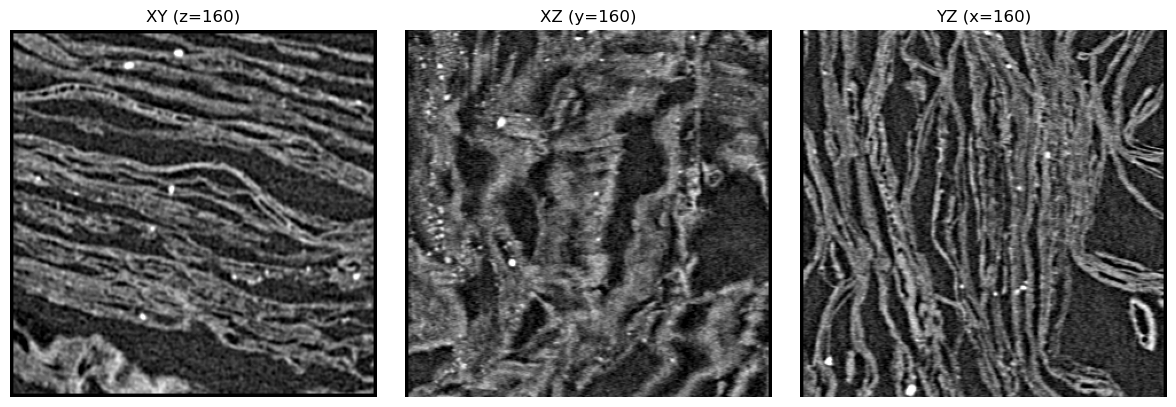

In [4]:
import torch
import matplotlib.pyplot as plt

# x: torch.Tensor, shape (Z,H,W)
x = x.cpu()
Z, H, W = x.shape

z0, y0, x0 = Z//2, H//2, W//2

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(x[z0].numpy(), cmap="gray")          # XY plane
plt.title(f"XY (z={z0})")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(x[:, y0, :].numpy(), cmap="gray")    # XZ plane
plt.title(f"XZ (y={y0})")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(x[:, :, x0].numpy(), cmap="gray")    # YZ plane
plt.title(f"YZ (x={x0})")
plt.axis("off")

plt.tight_layout()
plt.show()


# Scroll Indices

In [19]:
import pandas as pd
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df.head()
print("Train DataFrame Shape: ", train_df.shape)

Train DataFrame Shape:  (806, 2)


## Z축 슬라이스 여러 장 한 번에 훑기

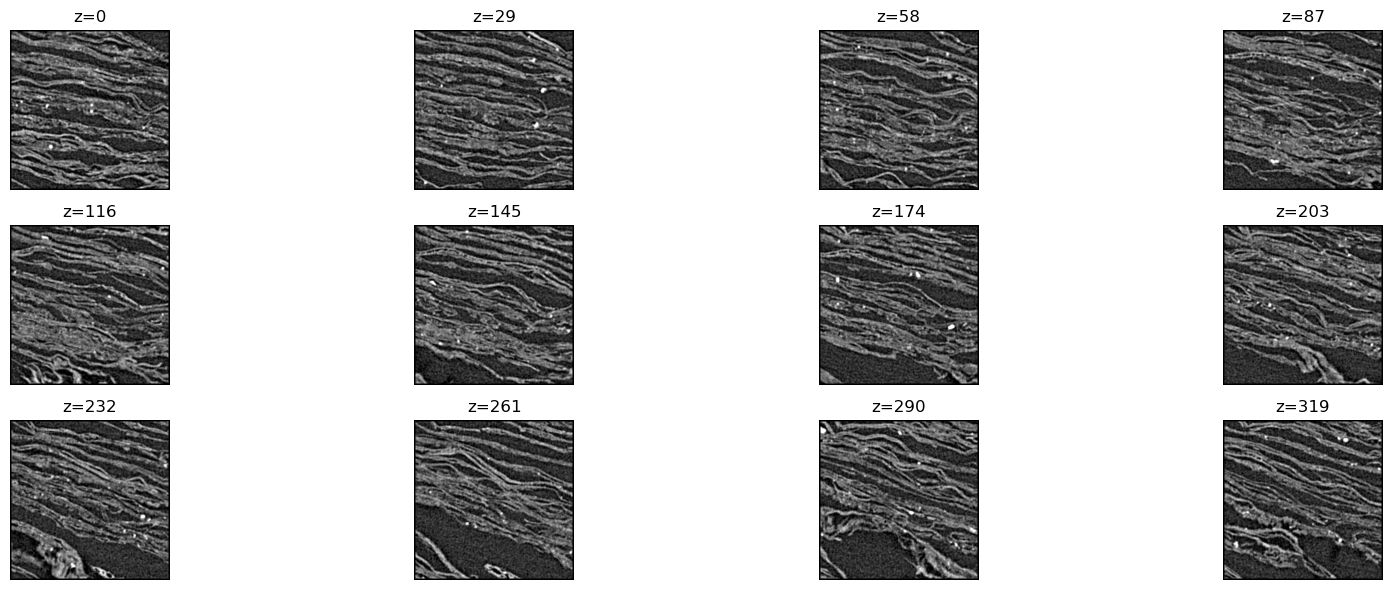

In [5]:
import matplotlib.pyplot as plt
import numpy as np

x = x.cpu()
Z = x.shape[0]

idxs = np.linspace(0, Z-1, 12).astype(int)

plt.figure(figsize=(18,6))
for i, z in enumerate(idxs, 1):
    plt.subplot(3, 4, i)
    plt.imshow(x[z].numpy(), cmap="gray")
    plt.title(f"z={z}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## 슬라이더로 z를 움직이며 보기

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

def to_numpy(t):
    import torch
    if hasattr(t, "detach"):
        t = t.detach()
    if hasattr(t, "cpu"):
        t = t.cpu()
    return np.asarray(t)

def show_slice_triplet_012(vol, mask=None, z=0, alpha=0.35):
    V = to_numpy(vol)  # (Z,H,W)
    Z, H, W = V.shape
    z = int(np.clip(z, 0, Z - 1))

    img = V[:,z,:] 
    img_disp = img
    if img_disp.dtype != np.uint8:
        mn, mx = img_disp.min(), img_disp.max()
        img_disp = (img_disp - mn) / (mx - mn + 1e-6)

    # mask slice
    M = None
    if mask is not None:
        L = to_numpy(mask)
        if L.ndim == 3:
            M = L[:,z,:]
        elif L.ndim == 2:
            M = L
        else:
            raise ValueError(f"mask must be 2D or 3D, got {L.shape}")

    plt.figure(figsize=(15,5))

    # 1) image
    plt.subplot(1,3,1)
    plt.imshow(img_disp, cmap="gray")
    plt.title(f"Image (z={z})")
    plt.axis("off")

    # 2) raw mask (0/1/2)
    plt.subplot(1,3,2)
    if M is None:
        plt.text(0.5, 0.5, "No mask", ha="center", va="center")
    else:
        # 0/1/2가 구분되게 표시 (0=검정, 1=회색, 2=흰색)
        plt.imshow(M, vmin=0, vmax=2, cmap="gray")
        plt.title("Mask (raw: 0/1/2)")
    plt.axis("off")

    # 3) overlay (ink=red, unlabeled=blue)
    plt.subplot(1,3,3)
    plt.imshow(img_disp, cmap="gray")

    if M is not None:
        ink = (M == 1)
        unlabeled = (M == 2)

        overlay = np.zeros((H, W, 4), dtype=np.float32)

        # unlabeled -> blue
        overlay[..., 2] = 1.0
        overlay[..., 3] = alpha * unlabeled.astype(np.float32)
        plt.imshow(overlay)

        # ink -> red (위에 덮기)
        overlay2 = np.zeros((H, W, 4), dtype=np.float32)
        overlay2[..., 0] = 1.0
        overlay2[..., 3] = alpha * ink.astype(np.float32)
        plt.imshow(overlay2)

    plt.title("Overlay (red=ink, blue=unlabeled)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def slider_triplet_012(vol, mask):
    V = to_numpy(vol)
    Z = V.shape[0]
    interact(
        lambda z, alpha: show_slice_triplet_012(vol, mask, z=z, alpha=alpha),
        z=IntSlider(min=0, max=Z-1, step=1, value=Z//2),
        alpha=FloatSlider(min=0.0, max=0.9, step=0.05, value=0.35),
    )

slider_triplet_012(x, y)

interactive(children=(IntSlider(value=160, description='z', max=319), FloatSlider(value=0.35, description='alp…

In [12]:
# GIF 저장
import numpy as np
import imageio.v2 as imageio

def to_np(t):
    import torch
    if hasattr(t, "detach"): t = t.detach()
    if hasattr(t, "cpu"): t = t.cpu()
    return np.asarray(t)

# 입력
vol = to_np(x)      # (Z,H,W)
mask = to_np(y)  # (H,W) or (Z,H,W), values in {0,1,2}

Z, H, W = vol.shape
step = 1        # Z축 프레임 간격 (2~4 추천)
alpha = 0.35    # overlay 투명도

frames = []

for z in range(0, Z, step):
    # --- image slice ---
    img = vol[:,:,z]
    if img.dtype != np.uint8:
        img = ((img - img.min()) / (img.max() - img.min() + 1e-6) * 255).astype(np.uint8)

    img_rgb = np.stack([img, img, img], axis=-1).astype(np.float32)

    # --- mask slice ---
    if mask.ndim == 3:
        m = mask[:,:,z]
    else:
        m = mask

    # mask raw 시각화 (0=검정, 1=회색, 2=흰색)
    mask_raw = ((m / 2.0) * 255).astype(np.uint8)
    mask_rgb = np.stack([mask_raw]*3, axis=-1).astype(np.float32)

    # --- overlay ---
    overlay = img_rgb.copy()

    ink = (m == 1)
    unl = (m == 2)

    # unlabeled -> blue
    overlay[..., 2] = np.where(
        unl, (1 - alpha) * overlay[..., 2] + alpha * 255, overlay[..., 2]
    )

    # ink -> red
    overlay[..., 0] = np.where(
        ink, (1 - alpha) * overlay[..., 0] + alpha * 255, overlay[..., 0]
    )

    # --- 3패널 가로로 붙이기 ---
    panel = np.concatenate(
        [
            img_rgb.clip(0,255).astype(np.uint8),
            mask_rgb.clip(0,255).astype(np.uint8),
            overlay.clip(0,255).astype(np.uint8),
        ],
        axis=1,   # 가로 방향
    )

    frames.append(panel)

# --- GIF 저장 ---
imageio.mimsave("vesuvius_image_mask_overlay_y.gif", frames, fps=10)
print("saved: vesuvius_image_mask_overlay_y.gif")



saved: vesuvius_image_mask_overlay_y.gif


## Napari 3d 렌더링

In [8]:
import napari
import numpy as np

V = x.detach().cpu().numpy()    # (Z,H,W)
viewer = napari.Viewer(ndisplay=3)

# rendering 옵션: "mip"가 빠르고 잘 보임 (최대강도투영)
viewer.add_image(V, name="volume", rendering="mip")

# 라벨까지 올리고 싶으면 (0/1/2)
L = y.detach().cpu().numpy()
viewer.add_labels(L.astype(np.int32), name="label_012")

napari.run()


## PyVista 등치면 확인 (Blob체크)